## Telecommunication Sector Model

In [1]:
#%pip install quandl

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import quandl
from sklearn.metrics import mean_absolute_error as mae
from functools import reduce


### Load target variable data

In [3]:
# Load P/E ratio -- data manually downloaded from Capital IQ
pe_ratio = pd.read_csv('PE_daily_normalized_tele.csv')
pe_ratio.head()

,Dates,PE
0,Aug-24-2001,21.84x
1,Aug-27-2001,21.54x
2,Aug-28-2001,21.34x
3,Aug-29-2001,21.16x
4,Aug-30-2001,21.09x


In [4]:
# load telecommunication index price -- also from Capital IQ
price = pd.read_csv('daily_price_tele.csv')
price.head()

,Dates,Value
0,Aug-01-2001,198.68
1,Aug-02-2001,195.27
2,Aug-03-2001,193.28
3,Aug-06-2001,191.48
4,Aug-07-2001,191.19


In [5]:
# load 10 year treasury rate
quandl.ApiConfig.api_key = "91nyd8SyzTFzVtMSfKPJ"

treasury = quandl.get("FRED/DGS10")
treasury.head()

,Value
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


### Transform

In [6]:
# rename, change type
pe_ratio = pe_ratio.rename(columns = {"Dates": "Date", "PE" : "PE"})
pe_ratio['Date'] = pd.to_datetime(pe_ratio['Date'])
pe_ratio = pe_ratio.set_index('Date')

pe_ratio['PE'] = pe_ratio['PE'].str.rstrip('x')
pe_ratio['PE'] = pd.to_numeric(pe_ratio['PE'])
pe_ratio.head()

,PE
Date,
2001-08-24,21.84
2001-08-27,21.54
2001-08-28,21.34
2001-08-29,21.16
2001-08-30,21.09


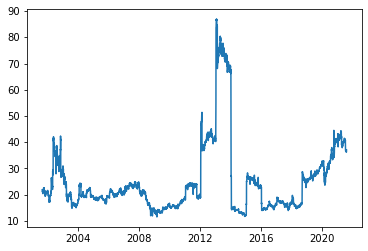

In [7]:
plt.plot(pe_ratio.PE)

In [8]:
# rename, change type
price = price.rename(columns = {"Dates": "Date", "Value" : "Price"})
price['Date'] = pd.to_datetime(price['Date'])
price = price.set_index('Date')

price.head()

,Price
Date,
2001-08-01,198.68
2001-08-02,195.27
2001-08-03,193.28
2001-08-06,191.48
2001-08-07,191.19


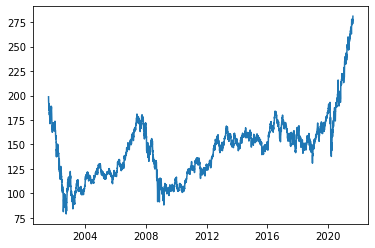

In [9]:
plt.plot(price.Price)

In [10]:
treasury = treasury.rename(columns = {"Value" : "treasury_rate"})
treasury.head()

,treasury_rate
Date,
1962-01-02,4.06
1962-01-03,4.03
1962-01-04,3.99
1962-01-05,4.02
1962-01-08,4.03


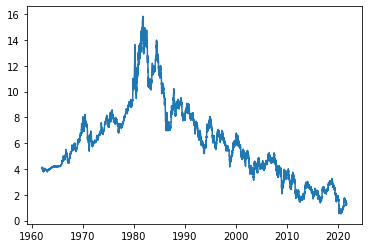

In [11]:
plt.plot(treasury.treasury_rate)

### Transform to monthly average

In [12]:
joined = pe_ratio.join(price).join(treasury)
joined.head()

,PE,Price,treasury_rate
Date,,,
2001-08-24,21.84,183.24,4.93
2001-08-27,21.54,180.65,4.94
2001-08-28,21.34,179.19,4.85
2001-08-29,21.16,177.58,4.78
2001-08-30,21.09,176.92,4.79


In [13]:
joined['month'] = joined.index.month
joined['year'] = joined.index.year

joined = joined.groupby([joined.year, joined.month]).mean()
joined.head()

PE       Price  treasury_rate
year month                                      
2001 8      21.358333  179.221667       4.856667
     9      21.543333  180.474000       4.748667
     10     21.277391  177.617391       4.566818
     11     20.492381  167.864762       4.651500
     12     20.719000  167.026000       5.087500

In [14]:
joined = joined.reset_index()
joined['date'] = pd.to_datetime(joined[['year', 'month']].assign(DAY=1))
joined = joined.set_index('date')
joined.head()

,year,month,PE,Price,treasury_rate
date,,,,,
2001-08-01,2001,8,21.358333,179.221667,4.856667
2001-09-01,2001,9,21.543333,180.474000,4.748667
2001-10-01,2001,10,21.277391,177.617391,4.566818
2001-11-01,2001,11,20.492381,167.864762,4.651500
2001-12-01,2001,12,20.719000,167.026000,5.087500


In [15]:
joined['earnings'] = joined.Price / joined.PE
joined.head()

,year,month,PE,Price,treasury_rate,earnings
date,,,,,,
2001-08-01,2001,8,21.358333,179.221667,4.856667,8.391182
2001-09-01,2001,9,21.543333,180.474000,4.748667,8.377255
2001-10-01,2001,10,21.277391,177.617391,4.566818,8.347705
2001-11-01,2001,11,20.492381,167.864762,4.651500,8.191569
2001-12-01,2001,12,20.719000,167.026000,5.087500,8.061489


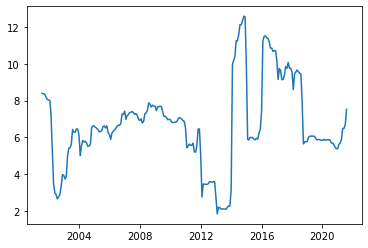

In [16]:
plt.plot(joined.earnings)

In [17]:
joined['earnings_change'] = joined.earnings.pct_change()
display(joined)

,year,month,PE,Price,treasury_rate,earnings,earnings_change
date,,,,,,,
2001-08-01,2001,8,21.358333,179.221667,4.856667,8.391182,NaN
2001-09-01,2001,9,21.543333,180.474000,4.748667,8.377255,-0.001660
2001-10-01,2001,10,21.277391,177.617391,4.566818,8.347705,-0.003527
2001-11-01,2001,11,20.492381,167.864762,4.651500,8.191569,-0.018704
2001-12-01,2001,12,20.719000,167.026000,5.087500,8.061489,-0.015880
...,...,...,...,...,...,...,...
2021-04-01,2021,4,42.774500,251.382000,1.628000,5.876913,0.031792
2021-05-01,2021,5,39.058500,253.229000,1.621000,6.483326,0.103186
2021-06-01,2021,6,40.197368,260.633684,1.524211,6.483849,0.000081


In [18]:
#set the cap
#joined.loc[joined['earnings_change'] > 0.5] = 0.5

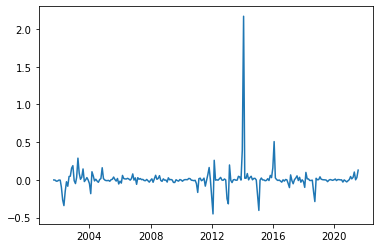

In [19]:
plt.plot(joined.earnings_change)

In [20]:
joined['target'] = joined.earnings_change - ((1 + joined.treasury_rate/100)**(1/12) - 1)
joined = joined.dropna()
joined.head()

,year,month,PE,Price,treasury_rate,earnings,earnings_change,target
date,,,,,,,,
2001-09-01,2001,9,21.543333,180.474000,4.748667,8.377255,-0.001660,-0.005533
2001-10-01,2001,10,21.277391,177.617391,4.566818,8.347705,-0.003527,-0.007256
2001-11-01,2001,11,20.492381,167.864762,4.651500,8.191569,-0.018704,-0.022500
2001-12-01,2001,12,20.719000,167.026000,5.087500,8.061489,-0.015880,-0.020024
2002-01-01,2002,1,20.239048,162.613810,5.035714,8.034657,-0.003328,-0.007431


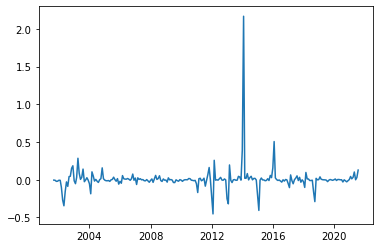

In [21]:
plt.plot(joined.target)

In [22]:
target = joined['target'].to_frame()
target.head()

,target
date,
2001-09-01,-0.005533
2001-10-01,-0.007256
2001-11-01,-0.022500
2001-12-01,-0.020024
2002-01-01,-0.007431


## Load exogenous Variables

In [23]:
def get_df_name(df):
    # grabs name of dataframe to be used as variable name
    name =[x for x in globals() if globals()[x] is df][0]
    return name

def var_change(df):
    df_name = get_df_name(df)
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['Date'] = pd.to_datetime(df[['year', 'month']].assign(DAY=1))
    df = df.set_index('Date')

    df = df.rename(columns = {'Value':df_name}).drop(columns = ['year', 'month'])

    df_mom_ch = df.rename(columns = {df_name : df_name + '_mom_ch'})
    df_mom_ch = df_mom_ch[df_name + '_mom_ch'].diff(1)/ df_mom_ch[df_name + '_mom_ch']

    df_yoy_ch = df.rename(columns = {df_name : df_name + '_yoy_ch'})
    df_yoy_ch = df_yoy_ch[df_name + '_yoy_ch'].diff(12)/ df_yoy_ch[df_name + '_yoy_ch']

    df_final = pd.DataFrame(df_mom_ch).join(df_yoy_ch).join(df)
    
    return df_final

## Load Quandl indicators

In [24]:
# CPIAUCSL - Consumer Price Index for All Urban Consumers: All Items in U.S. City Average 
cpi = quandl.get('FRED/CPIAUCSL')
cpi.head()

,Value
Date,
1947-01-01,21.48
1947-02-01,21.62
1947-03-01,22.00
1947-04-01,22.00
1947-05-01,21.95


In [25]:
# WPU117601 - Producer Price Index by Commodity: Machinery and Equipment: Telephone and Wireline Data Networking Equipment
ppi_w = quandl.get('FRED/WPU117601')
ppi_w.head()

,Value
Date,
1985-12-01,100.0
1986-01-01,101.1
1986-02-01,101.1
1986-03-01,101.4
1986-04-01,101.4


In [26]:
# ITMTCIM133S - U.S. Imports of Services: Telecommunications, Computer, and Information Services
imp = quandl.get('FRED/ITMTCIM133S')
imp.head()

,Value
Date,
1999-01-01,1252.0
1999-02-01,1252.0
1999-03-01,1252.0
1999-04-01,1252.0
1999-05-01,1249.0


In [27]:
# ITXTCIM133S - U.S. Exports of Services: Telecommunications, Computer, and Information Services
exp = quandl.get('FRED/ITXTCIM133S')
exp.head()

,Value
Date,
1999-01-01,1019.0
1999-02-01,1018.0
1999-03-01,1016.0
1999-04-01,1012.0
1999-05-01,1011.0


In [28]:
# find month-on-month growth and year-on-year growth
cpi_new = var_change(cpi)
ppi_w_new = var_change(ppi_w)
imp_new = var_change(imp)
exp_new = var_change(exp)

### Joined dataframe

In [29]:
# join all exogenous variables
ex_list = [cpi_new,ppi_w_new,imp_new,exp_new]
ex_merged = reduce(lambda  left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), ex_list)
ex_merged.head()

,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,exp_mom_ch,exp_yoy_ch,exp
Date,,,,,,,,,,,,
1947-01-01,NaN,NaN,21.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-02-01,0.006475,NaN,21.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-03-01,0.017273,NaN,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-04-01,0.000000,NaN,22.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1947-05-01,-0.002278,NaN,21.95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
ex_final = ex_merged
ex_final.columns

Index(['cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'ppi_w_mom_ch', 'ppi_w_yoy_ch',
       'ppi_w', 'imp_mom_ch', 'imp_yoy_ch', 'imp', 'exp_mom_ch', 'exp_yoy_ch',
       'exp'],
      dtype='object')

### Create feature lags

In [31]:
# this lags features in ex_columns in the range of periods in lag_periods

ex_columns = ['cpi_mom_ch', 'cpi_yoy_ch', 'cpi', 'ppi_w_mom_ch', 'ppi_w_yoy_ch',
       'ppi_w', 'imp_mom_ch', 'imp_yoy_ch', 'imp', 'exp_mom_ch', 'exp_yoy_ch',
       'exp']

lag_periods = list(range(1,14))
def add_lags(var_names, lag_periods):
    for var in var_names:
        for lag in lag_periods:
            var_col = var + '_' + str(lag)
            ex_final[var_col] = ex_final[var].shift(lag)
            
add_lags(ex_columns, lag_periods)

In [32]:
st = pd.read_csv('st_prediction.csv')
st['Date'] = pd.to_datetime(st['Date'])
st = st.set_index('Date')
st['market1'] = pd.to_numeric(st['market1'])
st.head()

,market1
Date,
2001-09-01,-0.450016
2001-10-01,-0.414976
2001-11-01,-0.242129
2001-12-01,-0.608143
2002-01-01,-0.612288


In [33]:
# join with target variable

df = st.join(ex_final)
final_df = target.join(df)
final_df.head()

,target,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
date,,,,,,,,,,,,,,,,,,,,,
2001-09-01,-0.005533,-0.450016,0.003930,0.025267,178.1,0.000000,-0.056459,104.5,-0.013605,-0.002551,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0
2001-10-01,-0.007256,-0.414976,-0.002815,0.020833,177.6,0.000000,-0.054545,104.5,-0.025283,-0.024412,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0
2001-11-01,-0.022500,-0.242129,-0.000563,0.018592,177.5,-0.001918,-0.056568,104.3,-0.015044,-0.037168,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0
2001-12-01,-0.020024,-0.608143,-0.000564,0.015784,177.4,0.000000,-0.056568,104.3,-0.002662,-0.038154,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0
2002-01-01,-0.007431,-0.612288,0.001688,0.011818,177.7,-0.000960,-0.057582,104.2,0.008795,-0.028144,...,1059.0,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0


In [34]:
# look at any NAs
final_df[final_df.isna().any(1)]

,target,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
date,,,,,,,,,,,,,,,,,,,,,
2021-04-01,0.030445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-05-01,0.101845,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,-0.001181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-07-01,0.028076,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-01,0.127284,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# remove latest periods with missing data
df = final_df.iloc[:-5]
df.tail()

,target,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
date,,,,,,,,,,,,,,,,,,,,,
2020-11-01,-0.028466,0.009809,0.001782,0.011260,260.927,0.008424,0.007220,83.1,0.030285,-0.066745,...,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0
2020-12-01,-0.014038,-0.000538,0.002420,0.012835,261.560,0.003597,0.007194,83.4,0.016484,-0.021689,...,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0
2021-01-01,0.001549,-0.000172,0.002559,0.013515,262.231,-0.009685,0.013317,82.6,-0.035019,-0.007483,...,4647.0,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0
2021-02-01,0.042618,-0.000759,0.003534,0.016480,263.161,0.003619,0.007238,82.9,-0.018287,0.006705,...,4989.0,4647.0,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0
2021-03-01,0.011291,-0.000566,0.006163,0.025696,264.793,-0.004848,-0.003636,82.5,-0.001221,0.031431,...,5208.0,4989.0,4647.0,4451.0,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0


## Feature Correlation

In [36]:
var_corr = (df.corr().sort_values('target'))
var_corr.tail()

,target,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
imp_mom_ch_9,0.115069,0.128413,0.002008,0.247684,-0.162923,0.048076,-0.014429,0.041000,-0.228757,0.476836,...,-0.204432,-0.206871,-0.208526,-0.209764,-0.212314,-0.217074,-0.223293,-0.230087,-0.236462,-0.242000
ppi_w_yoy_ch_1,0.120972,-0.293096,-0.058252,-0.169810,0.687145,0.010201,0.918835,-0.674787,-0.029749,-0.068949,...,0.594803,0.592308,0.589509,0.586828,0.584508,0.582323,0.580177,0.577924,0.575895,0.574192
ppi_w_yoy_ch_2,0.124468,-0.290504,-0.010634,-0.160093,0.690214,0.010328,0.850089,-0.686380,-0.036884,-0.070556,...,0.597571,0.595455,0.592796,0.589918,0.587282,0.584981,0.582743,0.580574,0.578313,0.576281
imp_mom_ch_10,0.144623,0.069834,-0.010904,0.214157,-0.151209,0.057236,-0.002626,0.036071,-0.115754,0.407704,...,-0.190591,-0.192365,-0.195366,-0.197969,-0.199758,-0.202409,-0.206816,-0.212779,-0.219391,-0.225716
target,1.000000,-0.048456,-0.058515,-0.014914,0.028942,0.055558,0.108407,-0.035535,0.061542,0.105270,...,0.026239,0.022830,0.020253,0.018561,0.017770,0.017399,0.017369,0.017417,0.017542,0.018226


In [37]:
var_corr

,target,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,...,exp_4,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13
cpi_yoy_ch_10,-0.123838,-0.243939,0.040154,0.084825,-0.288416,-0.013268,-0.105062,0.235847,-0.016868,-0.088871,...,-0.314906,-0.315794,-0.316017,-0.316065,-0.315495,-0.313947,-0.311834,-0.310461,-0.310772,-0.312688
cpi_yoy_ch_11,-0.102447,-0.228583,0.022016,0.005331,-0.285688,-0.019186,-0.097925,0.240967,-0.044536,-0.126193,...,-0.306699,-0.308990,-0.310439,-0.311716,-0.312395,-0.311932,-0.309920,-0.307441,-0.305779,-0.305974
cpi_yoy_ch_9,-0.100167,-0.272079,0.029977,0.157066,-0.288958,-0.026632,-0.114132,0.228766,0.009210,-0.041499,...,-0.318254,-0.318224,-0.317732,-0.316817,-0.315210,-0.313360,-0.312186,-0.312646,-0.314615,-0.317517
cpi_mom_ch_11,-0.092327,-0.067938,0.037886,0.266680,-0.109432,0.005623,-0.043596,0.076850,-0.113358,0.041106,...,-0.131790,-0.128644,-0.124579,-0.121068,-0.118053,-0.116282,-0.116383,-0.119396,-0.124691,-0.130857
cpi_mom_ch_10,-0.092012,-0.104800,0.057273,0.363114,-0.116181,0.037491,-0.082860,0.079405,-0.070077,0.105643,...,-0.135796,-0.131358,-0.127133,-0.123702,-0.121867,-0.122276,-0.125514,-0.130968,-0.137174,-0.141921
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
imp_mom_ch_9,0.115069,0.128413,0.002008,0.247684,-0.162923,0.048076,-0.014429,0.041000,-0.228757,0.476836,...,-0.204432,-0.206871,-0.208526,-0.209764,-0.212314,-0.217074,-0.223293,-0.230087,-0.236462,-0.242000
ppi_w_yoy_ch_1,0.120972,-0.293096,-0.058252,-0.169810,0.687145,0.010201,0.918835,-0.674787,-0.029749,-0.068949,...,0.594803,0.592308,0.589509,0.586828,0.584508,0.582323,0.580177,0.577924,0.575895,0.574192
ppi_w_yoy_ch_2,0.124468,-0.290504,-0.010634,-0.160093,0.690214,0.010328,0.850089,-0.686380,-0.036884,-0.070556,...,0.597571,0.595455,0.592796,0.589918,0.587282,0.584981,0.582743,0.580574,0.578313,0.576281
imp_mom_ch_10,0.144623,0.069834,-0.010904,0.214157,-0.151209,0.057236,-0.002626,0.036071,-0.115754,0.407704,...,-0.190591,-0.192365,-0.195366,-0.197969,-0.199758,-0.202409,-0.206816,-0.212779,-0.219391,-0.225716


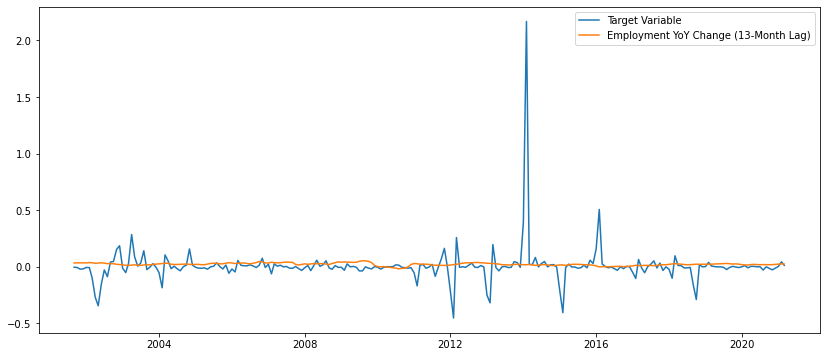

In [38]:
plt.figure(figsize = (14, 6))
plt.plot(df.target, label = 'Target Variable')
plt.plot(df.cpi_yoy_ch_13, label = 'Employment YoY Change (13-Month Lag)')
plt.legend()

Notes:
- we would include highest and lowest correlation features
- in 1-2 months ahead, soc and unemp have large correlation
- around half year: cpi has large correlation
- 10-plus periods: unemp and emp 

## Shift target variables for 1, 3, 6, 12, 18 months

In [39]:
df_1 = df
df_1 = df_1.reset_index()
df_1['target'] = df_1.target.shift(-1)
df_1['date'] = df_1.date.shift(-1)
df_1 = df_1.dropna()
df_1 = df_1.set_index('date')
df_1['month'] = df_1.index.month
df_1

,target,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-10-01,-0.007256,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,104.5,-0.013605,-0.002551,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,10
2001-11-01,-0.022500,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,104.5,-0.025283,-0.024412,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,11
2001-12-01,-0.020024,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,104.3,-0.015044,-0.037168,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,12
2002-01-01,-0.007431,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,104.3,-0.002662,-0.038154,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1
2002-02-01,-0.008379,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,104.2,0.008795,-0.028144,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,-0.028466,0.013084,0.001202,0.011806,260.462,-0.009709,0.010922,82.4,0.045179,-0.106731,...,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,4675.0,11
2020-12-01,-0.014038,0.009809,0.001782,0.011260,260.927,0.008424,0.007220,83.1,0.030285,-0.066745,...,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,12
2021-01-01,0.001549,-0.000538,0.002420,0.012835,261.560,0.003597,0.007194,83.4,0.016484,-0.021689,...,4403.0,4505.0,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,1


In [40]:
df_3 = df
df_3 = df_3.reset_index()
df_3['target'] = df_3.target.shift(-3)
df_3['date'] = df_3.date.shift(-3)
df_3 = df_3.dropna()
df_3 = df_3.set_index('date')
df_3['month'] = df_3.index.month
df_3

,target,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-12-01,-0.020024,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,104.5,-0.013605,-0.002551,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,12
2002-01-01,-0.007431,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,104.5,-0.025283,-0.024412,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1
2002-02-01,-0.008379,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,104.3,-0.015044,-0.037168,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,2
2002-03-01,-0.099550,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,104.3,-0.002662,-0.038154,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,3
2002-04-01,-0.270032,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,104.2,0.008795,-0.028144,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,-0.028466,0.109614,0.003495,0.013075,259.511,0.002410,0.006024,83.0,0.005871,-0.168950,...,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,4675.0,4670.0,4672.0,11
2020-12-01,-0.014038,0.023037,0.002452,0.013904,260.149,0.002404,0.006010,83.2,0.026358,-0.142903,...,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,4675.0,4670.0,12
2021-01-01,0.001549,0.013084,0.001202,0.011806,260.462,-0.009709,0.010922,82.4,0.045179,-0.106731,...,4580.0,4634.0,4642.0,4646.0,4669.0,4685.0,4691.0,4688.0,4675.0,1


In [41]:
df_6 = df
df_6 = df_6.reset_index()
df_6['target'] = df_6.target.shift(-6)
df_6['date'] = df_6.date.shift(-6)
df_6 = df_6.dropna()
df_6 = df_6.set_index('date')
df_6['month'] = df_6.index.month
df_6

,target,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2002-03-01,-0.099550,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,104.5,-0.013605,-0.002551,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,3
2002-04-01,-0.270032,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,104.5,-0.025283,-0.024412,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,4
2002-05-01,-0.346031,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,104.3,-0.015044,-0.037168,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,5
2002-06-01,-0.156167,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,104.3,-0.002662,-0.038154,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,6
2002-07-01,-0.029472,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,104.2,0.008795,-0.028144,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,-0.028466,-0.453452,-0.000977,0.002231,255.942,0.010870,0.000000,82.8,-0.003829,-0.169113,...,4685.0,4691.0,4688.0,4675.0,4670.0,4672.0,4682.0,4636.0,4532.0,11
2020-12-01,-0.014038,0.368348,0.005208,0.007226,257.282,-0.009756,-0.009756,82.0,-0.011947,-0.181789,...,4669.0,4685.0,4691.0,4688.0,4675.0,4670.0,4672.0,4682.0,4636.0,12
2021-01-01,0.001549,0.192666,0.005112,0.010359,258.604,0.009662,0.000000,82.8,-0.016076,-0.182743,...,4646.0,4669.0,4685.0,4691.0,4688.0,4675.0,4670.0,4672.0,4682.0,1


In [42]:
df_12 = df
df_12 = df_12.reset_index()
df_12['target'] = df_12.target.shift(-12)
df_12['date'] = df_12.date.shift(-12)
df_12 = df_12.dropna()
df_12 = df_12.set_index('date')
df_12['month'] = df_12.index.month
df_12

,target,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2002-09-01,0.040499,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,104.5,-0.013605,-0.002551,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,9
2002-10-01,0.045425,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,104.5,-0.025283,-0.024412,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,10
2002-11-01,0.151730,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,104.3,-0.015044,-0.037168,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,11
2002-12-01,0.184430,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,104.3,-0.002662,-0.038154,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,12
2003-01-01,-0.014347,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,104.2,0.008795,-0.028144,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,-0.028466,0.008040,0.002333,0.020028,257.989,0.012121,-0.001212,82.5,-0.006064,0.036659,...,4682.0,4636.0,4532.0,4372.0,4262.0,4203.0,4194.0,4156.0,4090.0,11
2020-12-01,-0.014038,0.024932,0.000829,0.022114,258.203,0.003623,0.000000,82.8,-0.026889,0.015001,...,4672.0,4682.0,4636.0,4532.0,4372.0,4262.0,4203.0,4194.0,4156.0,12
2021-01-01,0.001549,0.047709,0.001871,0.024145,258.687,-0.015951,-0.019632,81.5,-0.049614,-0.024361,...,4670.0,4672.0,4682.0,4636.0,4532.0,4372.0,4262.0,4203.0,4194.0,1


In [43]:
df_18 = df
df_18 = df_18.reset_index()
df_18['target'] = df_18.target.shift(-18)
df_18['date'] = df_18.date.shift(-18)
df_18 = df_18.dropna()
df_18 = df_18.set_index('date')
df_18['month'] = df_18.index.month
df_18

,target,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2003-03-01,0.028986,-0.450016,0.003930,0.025267,178.100,0.000000,-0.056459,104.5,-0.013605,-0.002551,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,3
2003-04-01,0.284133,-0.414976,-0.002815,0.020833,177.600,0.000000,-0.054545,104.5,-0.025283,-0.024412,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,4
2003-05-01,0.086355,-0.242129,-0.000563,0.018592,177.500,-0.001918,-0.056568,104.3,-0.015044,-0.037168,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,5
2003-06-01,0.004287,-0.608143,-0.000564,0.015784,177.400,0.000000,-0.056568,104.3,-0.002662,-0.038154,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,6
2003-07-01,0.030822,-0.612288,0.001688,0.011818,177.700,-0.000960,-0.057582,104.2,0.008795,-0.028144,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-11-01,-0.028466,-0.026062,0.000176,0.017954,255.371,0.001208,-0.006039,82.8,0.013373,0.058406,...,4194.0,4156.0,4090.0,3995.0,3958.0,3977.0,4054.0,4114.0,4156.0,11
2020-12-01,-0.014038,-0.004718,0.000204,0.016721,255.423,0.000000,-0.006039,82.8,-0.001093,0.057923,...,4203.0,4194.0,4156.0,4090.0,3995.0,3958.0,3977.0,4054.0,4114.0,12
2021-01-01,0.001549,0.002027,0.001962,0.017896,255.925,0.000000,0.003623,82.8,-0.015257,0.043273,...,4262.0,4203.0,4194.0,4156.0,4090.0,3995.0,3958.0,3977.0,4054.0,1


# Model

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")
import pmdarima as pm
from datetime import timedelta
from dateutil.relativedelta import relativedelta
from PlotForecast import plot_forecast

## SARIMA Model - 1 month

In [45]:
var_corr_1 = (df_1.corr().sort_values('target'))
var_corr_1.head()

,target,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
cpi_yoy_ch_9,-0.123868,-0.274127,0.037334,0.159971,-0.283271,-0.029645,-0.111905,0.225135,0.007448,-0.042659,...,-0.312094,-0.312164,-0.311600,-0.310042,-0.307913,-0.306528,-0.306838,-0.308764,-0.311641,0.021633
ppi_w_yoy_ch_13,-0.113896,-0.193690,-0.119813,-0.416314,0.622832,0.116622,0.459604,-0.547235,-0.160783,-0.292298,...,0.572342,0.574269,0.575958,0.576905,0.577069,0.576254,0.575264,0.574255,0.573380,-0.012553
cpi_yoy_ch_10,-0.102422,-0.247012,0.050484,0.088654,-0.280147,-0.017414,-0.102044,0.230979,-0.019449,-0.090787,...,-0.306497,-0.307804,-0.308496,-0.308029,-0.306002,-0.303505,-0.301831,-0.302025,-0.303859,0.013686
cpi_yoy_ch_8,-0.100138,-0.274607,0.024551,0.232203,-0.283559,-0.011124,-0.107347,0.219224,-0.006250,0.009279,...,-0.313808,-0.312910,-0.311302,-0.309441,-0.308257,-0.308715,-0.310693,-0.313611,-0.316797,0.020098
cpi_mom_ch_10,-0.092322,-0.106022,0.063335,0.365839,-0.110469,0.035253,-0.080979,0.075945,-0.071641,0.104996,...,-0.124859,-0.121332,-0.118305,-0.116529,-0.116631,-0.119655,-0.124968,-0.131154,-0.135878,-0.095100


In [46]:
var_corr_1.tail()

,target,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
imp_mom_ch_8,0.115004,0.158379,-0.006833,0.277806,-0.167271,0.019719,-0.028204,0.041230,-0.112205,0.502016,...,-0.211571,-0.212792,-0.215343,-0.220121,-0.226366,-0.233189,-0.239590,-0.245149,-0.249503,-0.057253
ppi_w_yoy_ch,0.121649,-0.291861,-0.082235,-0.163484,0.682042,0.257672,1.000000,-0.658069,-0.046654,-0.071559,...,0.585818,0.583147,0.580814,0.578597,0.576415,0.574122,0.572060,0.570331,0.569239,0.011009
ppi_w_yoy_ch_1,0.124765,-0.292619,-0.065918,-0.172799,0.685104,0.013197,0.919262,-0.673255,-0.028026,-0.068081,...,0.589410,0.586535,0.583887,0.581564,0.579301,0.577107,0.574821,0.572769,0.571047,0.007967
imp_mom_ch_9,0.144572,0.127433,0.009677,0.251150,-0.155515,0.045125,-0.011694,0.036152,-0.231434,0.477198,...,-0.198747,-0.201336,-0.203122,-0.205785,-0.210212,-0.216202,-0.222842,-0.229192,-0.234709,0.015768
target,1.000000,-0.021744,0.026938,0.010274,0.030189,0.012056,0.121649,-0.040525,0.072324,0.089081,...,0.019997,0.018301,0.017508,0.017136,0.017105,0.017153,0.017279,0.017965,0.019507,-0.016388


In [47]:
X1 = df_1.drop(['target'],axis = 1)
X1.head()

,market1,cpi_mom_ch,cpi_yoy_ch,cpi,ppi_w_mom_ch,ppi_w_yoy_ch,ppi_w,imp_mom_ch,imp_yoy_ch,imp,...,exp_5,exp_6,exp_7,exp_8,exp_9,exp_10,exp_11,exp_12,exp_13,month
date,,,,,,,,,,,,,,,,,,,,,
2001-10-01,-0.450016,0.003930,0.025267,178.1,0.000000,-0.056459,104.5,-0.013605,-0.002551,1176.0,...,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,1036.0,10
2001-11-01,-0.414976,-0.002815,0.020833,177.6,0.000000,-0.054545,104.5,-0.025283,-0.024412,1147.0,...,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,1045.0,11
2001-12-01,-0.242129,-0.000563,0.018592,177.5,-0.001918,-0.056568,104.3,-0.015044,-0.037168,1130.0,...,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1055.0,12
2002-01-01,-0.608143,-0.000564,0.015784,177.4,0.000000,-0.056568,104.3,-0.002662,-0.038154,1127.0,...,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,1066.0,1
2002-02-01,-0.612288,0.001688,0.011818,177.7,-0.000960,-0.057582,104.2,0.008795,-0.028144,1137.0,...,1069.0,1077.0,1082.0,1087.0,1092.0,1096.0,1095.0,1088.0,1077.0,2


In [48]:
y1 = df_1.target
y1

date
2001-10-01   -0.007256
2001-11-01   -0.022500
2001-12-01   -0.020024
2002-01-01   -0.007431
2002-02-01   -0.008379
                ...   
2020-11-01   -0.028466
2020-12-01   -0.014038
2021-01-01    0.001549
2021-02-01    0.042618
2021-03-01    0.011291
Name: target, Length: 234, dtype: float64

In [49]:
feature_names = X1.columns.values
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
rfe = RFE(LinearRegression(), 
          n_features_to_select=5, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X1,y1)
feature_names[rfe.get_support()]

array(['cpi_yoy_ch_2', 'ppi_w_mom_ch_1', 'ppi_w_mom_ch_13',
       'ppi_w_yoy_ch_1', 'ppi_w_yoy_ch_2'], dtype=object)

In [50]:
model_exvar = ['cpi_mom_ch', 'ppi_w_mom_ch_1', 'ppi_w_mom_ch_13',
       'ppi_w_yoy_ch_1', 'ppi_w_yoy_ch_2','market1']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_1.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_1.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

In [51]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                                   y   No. Observations:                  184
Model:             SARIMAX(0, 0, 1)x(2, 1, [], 12)   Log Likelihood                  25.643
Date:                             Tue, 31 Aug 2021   AIC                            -31.285
Time:                                     12:55:05   BIC                              0.190
Sample:                                          0   HQIC                           -18.515
                                             - 184                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             5.7257     11.336      0.505      0.613     -16.492      27.943
x2           139.4450    14

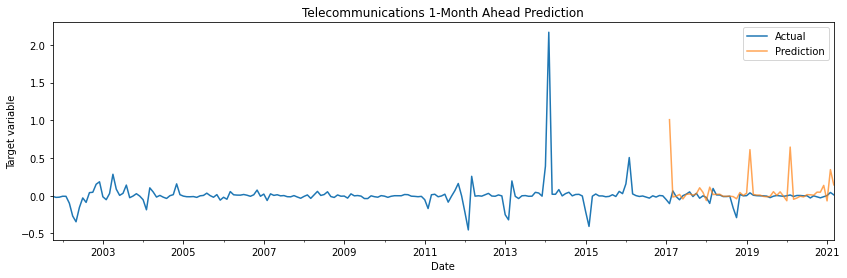

In [52]:
sarimax_model = SARIMAX(y_train, 
                order = (1,0,0), 
                seasonal_order = (2,1,0,12)
                , exog = x_train
                )

sarimax_mod_fit = sarimax_model.fit()

sarimax_pred = sarimax_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

sar_pred = sarimax_pred.predicted_mean
sar_pred_ci = sarimax_pred.conf_int()
ax = df_1.target.plot(label='Actual')
sar_pred.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 1-Month Ahead Prediction')
plt.legend()
plt.show()


In [53]:
def forecast_accuracy(forecast, actual):
    '''
    These are some accuracy metrics we use to compare how accurate our forecast values are.
    '''
    
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax                
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
            'corr':corr, 'minmax':minmax})

In [54]:
metrics1 = forecast_accuracy(y_test, sar_pred)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

MAPE: 1.55666
MAE: 0.09565


In [ ]:
sar1_pred = sarimax_pred.predicted_mean
sar1_pred_ci = sarimax_pred.conf_int()

pred_results1 = pd.DataFrame(df_1.target).join(sar1_pred).join(sar1_pred_ci)
pred_results1

In [ ]:
f = plot_forecast(data=pred_results1, data_index_col=0, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)

## SARIMAX Model - 3 month

In [ ]:
var_corr_3 = (df_3.corr().sort_values('target'))
var_corr_3.head()

In [ ]:
var_corr_3.tail()

In [ ]:
X3 = df_3.drop(['target'],axis = 1)
#X3.head()

In [ ]:
y3 = df_3.target
#y3

In [ ]:
feature_names = X3.columns.values
rfe = RFE(LinearRegression(), 
          n_features_to_select=10, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X3,y3)
feature_names[rfe.get_support()]

In [ ]:
model_exvar = ['cpi_mom_ch']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_3.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_3.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]



In [ ]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

In [ ]:
sar3_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (0,1,2,12)
                , exog = x_train
                )

sar3_mod_fit = sar3_model.fit()

sar3_pred = sar3_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

In [ ]:
sar3_pred_mean = sar3_pred.predicted_mean
sar3_pred_ci = sar3_pred.conf_int()
ax = df_3.target.plot(label='Actual')
sar3_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 3-Months Ahead Prediction')
plt.legend()
plt.show()

In [ ]:
metrics1 = forecast_accuracy(y_test, sar3_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

In [ ]:
pred_results3 = pd.DataFrame(df_3.target).join(sar3_pred_mean).join(sar3_pred_ci)
pred_results3

In [ ]:
f = plot_forecast(data=pred_results3, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)

## SARIMAX Model - 6 month

In [ ]:
var_corr_6 = (df_6.corr().sort_values('target'))
var_corr_6.head()

In [ ]:
var_corr_6.tail()

In [ ]:
X6 = df_6.drop(['target'],axis = 1)
#X6.head()

In [ ]:
y6 = df_6.target
#y6

In [ ]:
feature_names = X6.columns.values
rfe = RFE(LinearRegression(), 
          n_features_to_select=5, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X6,y6)
feature_names[rfe.get_support()]

In [ ]:
model_exvar = ['ppi_w_mom_ch']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_6.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_6.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]

In [ ]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

In [ ]:
sar6_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (0,1,2,12)
                , exog = x_train
                )

sar6_mod_fit = sar6_model.fit()

sar6_pred = sar6_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

In [ ]:
sar6_pred_mean = sar6_pred.predicted_mean
sar6_pred_ci = sar6_pred.conf_int()
ax = df_6.target.plot(label='Actual')
sar6_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 6-Months Ahead Prediction')
plt.legend()
plt.show()


In [ ]:
metrics1 = forecast_accuracy(y_test, sar6_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

In [ ]:
pred_results6 = pd.DataFrame(df_6.target).join(sar6_pred_mean).join(sar6_pred_ci)
pred_results6

In [ ]:
f = plot_forecast(data=pred_results6, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)

## SARIMAX Model - 12 month

In [ ]:
var_corr_12 = (df_12.corr().sort_values('target'))
var_corr_12.head()

In [ ]:
var_corr_12.tail()

In [ ]:
X12 = df_12.drop(['target'],axis = 1)
#X12.head()

In [ ]:
y12 = df_12.target
#y12

In [ ]:
feature_names = X12.columns.values
rfe = RFE(LinearRegression(), 
          n_features_to_select=10, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X12,y12)
feature_names[rfe.get_support()]

In [ ]:
model_exvar = ['cpi_mom_ch','exp_mom_ch_13']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_12.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_12.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]



In [ ]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

In [ ]:
sar12_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (1,1,1,12)
                , exog = x_train
                )

sar12_mod_fit = sar12_model.fit()

sar12_pred = sar12_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

In [ ]:
sar12_pred_mean = sar12_pred.predicted_mean
sar12_pred_ci = sar12_pred.conf_int()
ax = df_12.target.plot(label='Actual')
sar12_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 12-Months Ahead Prediction')
plt.legend()
plt.show()

In [ ]:
metrics1 = forecast_accuracy(y_test, sar12_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

In [ ]:
pred_results12 = pd.DataFrame(df_12.target).join(sar12_pred_mean).join(sar12_pred_ci)
pred_results12

In [ ]:
f = plot_forecast(data=pred_results12, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)

## SARIMAX Model - 18 month

In [ ]:
var_corr_18 = (df_18.corr().sort_values('target'))
var_corr_18.head()

In [ ]:
var_corr_18.tail()

In [ ]:
X18 = df_18.drop(['target'],axis = 1)
#X18.head()

In [ ]:
y18 = df_18.target
#y18

In [ ]:
feature_names = X18.columns.values
rfe = RFE(LinearRegression(), 
          n_features_to_select=10, # number of feature to retain
          step=1 # number of features to eliminate each round
         ).fit(X18,y18)
feature_names[rfe.get_support()]

In [ ]:
model_exvar = ['cpi_mom_ch_1']

# train test split
split_date = pd.Timestamp('2017-01-01')

train = df_18.loc[:split_date]
y_train = train['target']
x_train = train[model_exvar]

test =  df_18.loc[(split_date + relativedelta(months = 1)):]
y_test = test['target']
x_test = test[model_exvar]



In [ ]:
# Find p, q for sarimax model
results = pm.auto_arima(y_train, seasonal = True, m = 12, D = 1, information_criterion = 'aic', exogenous = np.array(x_train))
print(results.summary())

In [ ]:
sar18_model = SARIMAX(y_train, 
                order = (0,0,1), 
                seasonal_order = (0,1,2,12)
                , exog = x_train
                )

sar18_mod_fit = sar18_model.fit()

sar18_pred = sar18_mod_fit.get_prediction(start = y_test.index[0], end = y_test.index[-1], exog = x_test)

In [ ]:
sar18_pred_mean = sar18_pred.predicted_mean
sar18_pred_ci = sar18_pred.conf_int()
ax = df_18.target.plot(label='Actual')
sar18_pred_mean.plot(ax=ax, label='Prediction', alpha=.7, figsize=(14, 4))
ax.set_xlabel('Date')
ax.set_ylabel('Target variable')
plt.title('Telecommunications 18-Months Ahead Prediction')
plt.legend()
plt.show()

In [ ]:
metrics1 = forecast_accuracy(y_test, sar18_pred_mean)
print('MAPE: %0.5f' % metrics1['mape'])
print('MAE: %0.5f' % metrics1['mae'])

In [ ]:
pred_results18 = pd.DataFrame(df_18.target).join(sar18_pred_mean).join(sar18_pred_ci)
pred_results18

In [ ]:
f = plot_forecast(data=pred_results18, # <-- col to set as index / can also be 'ds' or wtvr
                  y='target', yhat='predicted_mean', ci_lower='lower target', ci_upper='upper target',
                  start_date = '2017-02-01',
                  print_mse=False)